Making a faster automatic GalaxyZoo classifier in Python
========================================================
[GalaxyZoo](https://www.galaxyzoo.org/) has a fabulous [data set](https://data.galaxyzoo.org/) for machine learning. There was a [Kaggle competition](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge) a few years back to create an automatic galaxy classifier based on the GalaxyZoo data, the winning entry ([code](https://github.com/benanne/kaggle-galaxies), [explanation](http://benanne.github.io/2014/04/05/galaxy-zoo.html)) works very well — but it takes days to initialize. Let's see if we can create something almost as good that runs much faster. (I'm using Python 3, but I'll try to make this notebook backwards compatible with Python 2 as well.)

I. Data retrieval and handling
-----------------
First, we need the [data from the Kaggle competition](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data) (the [raw GalaxyZoo data](http://data.galaxyzoo.org) is also available, but we don't need nearly that much data to get started). You'll need to create a Kaggle account (free) in order to access this. Download `images_training_rev1.zip` (~60,000 training images), `images_test_rev1.zip` (~80,000 test images), and `training_solutions_rev1.csv` (the classifications for the training images).

You'll also need the following Python packages (and their dependencies) installed:
* [NumPy](http://numpy.org) (v. 1.11.1)
* [pandas](http://pandas.pydata.org) (v. 0.18.1)
* [scikit-learn](http://scikit-learn.org) (0.18.dev0)
* [scikit-images](http://scikit-image.org/) (v. 0.12.3)

Let's start by testing out image reading, since that will be pretty important for this project.

In [ ]:
## An attempt at Python 2 backward compatibility
from __future__ import absolute_import, division, print_function, unicode_literals

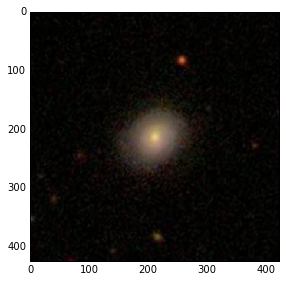

In [1]:
%matplotlib inline
from skimage import data, io, filters
filename = "images_training_rev1/100008.jpg"
galaxy = io.imread(filename)
io.imshow(galaxy)
io.show()

Next, let's have a look at the beginning of that CSV file of galaxy classifications.

In [2]:
import pandas as pd
training_solutions = pd.read_csv("training_solutions_rev1.csv",index_col=0)
training_solutions.head()

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,
100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Each column gives the fraction of answers given in the [Galaxy Zoo Decision Tree](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/details/the-galaxy-zoo-decision-tree). (There is a nice visualization of the tree [here](https://data.galaxyzoo.org/gz_trees/gz_trees.html), but annoyingly, the questions in that tree are indexed from 0, while the Kaggle set indexes them from 1.) So, for example, there are three possible answers to the first question, which is why we have columns Class 1.1, Class 1.2, and Class 1.3. For the first image (the one we displayed as a test, image `100008`, about 38.3% of users gave answer 1 to question 1, 61.7% gave answer 2, and nobody gave answer 3. 

The overall goal is to predict the distribution of all of these answers for all of the test images, given the above distribution for the training images. Let's get to work!

II. Trying something stupid, then trying something even stupider
---------------------------
Let's start with one of the dumbest "algorithms" imaginable: generating an entirely random set of answer distributions for each image. We won't even have to look at the images for this one! This will give us a baseline: if we can't do better than this, we're in trouble.

In [3]:
import os
import time
import numpy as np
from collections import OrderedDict

# First, let's find out exactly how many files there are in the training set.
# We could get this from the training set solution table, but let's just count the files instead.
training_filenames = os.listdir(path="images_training_rev1/")
# We need to make sure these are all images, rather than anything else that somehow ended up in the folder 
# (e.g. OSX invisible files)
training_filenames = [f for f in training_filenames if os.path.splitext(f)[1] == ".jpg"]
n_files = len(training_filenames)
print("There are", n_files, "files in the training set.")

# Now we need to know how many questions there are, and how many answers there are for each question. 
# To do that, let's have a look at the GalaxyZoo decision tree:
# https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/details/the-galaxy-zoo-decision-tree
# Again, we could pull this from the training set solution table, but I don't feel like doing that, 
# because regular expressions make me sad.
questions_dict = {
    1:3,
    2:2,
    3:2,
    4:2,
    5:4,
    6:2,
    7:3,
    8:7,
    9:3,
    10:3,
    11:6
                 }
questions_dict = OrderedDict(sorted(questions_dict.items()))
n_questions = len(questions_dict)
n_columns = sum(questions_dict[k] for k in questions_dict.keys())
print("There are", n_questions, "questions and", n_columns, "possible answers in the GalaxyZoo tree.")

def randrow():
    '''
    Creates a random row of numbers.
    Takes into account the constraints imposed by the number of questions:
    namely, that the total probability for each question must sum to 1.
    NB: returns a list, not an array.
    '''
    row = []
    for k in questions_dict.keys():
        n_answers = questions_dict[k]
        remaining_probability = 1
        while n_answers > 1:
            r = remaining_probability*np.random.random()
            row.append(r)
            remaining_probability -= r
            n_answers -= 1
        row.append(remaining_probability)
    return row

def randarray(rows):
    '''
    Returns a random array with the specified number of rows.
    Each row is generated using randrow().
    '''
    ra = [randrow() for i in range(rows)]
    return np.array(ra)

start = time.time()
ray = randarray(n_files)
delta_t = time.time()-start
print("Generated random array with shape", ray.shape, "in", delta_t, "seconds.")

There are 61578 files in the training set.
There are 11 questions and 37 possible answers in the GalaxyZoo tree.
Generated random array with shape (61578, 37) in 1.4801411628723145 seconds.


Now we have our terrible guess. But how terrible is it? [Kaggle uses root-mean-square error](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/details/evaluation) to evaluate the submissions for this competition. Let's do that — and let's compare our dumb idea against an even dumber one: an array full of ones.

In [4]:
from numpy import sqrt, asarray, ones
from sklearn.metrics import mean_squared_error
training_solutions_array = asarray(training_solutions)

def rmse(guess_array, test_array):
    '''Gives us the root-mean-squared error between the guess and the test set answers.'''
    rmse = sqrt(mean_squared_error(guess_array, test_array))
    return rmse

print("Error for our random array is", rmse(ray, training_solutions_array))
print("Error for an even sillier array (all ones) is", rmse(ones(training_solutions_array.shape), training_solutions_array))

Error for our random array is 0.373186821481
Error for an even sillier array (all ones) is 0.894771769035


Now we have our baseline. Just to be sure, let's generate a bunch of those random arrays and get the average RMSE across all of them. (Though, given the sheer number of elements in our arrays, it's likely that we'll get something very close to what we already have.)

In [82]:
n = 50
print("Generating", n, "random arrays...")
t1 = time.time()
random_errs = [rmse(randarray(n_files), training_solutions_array) for i in range(n)]
t2 = time.time()
print("Finished in", t2 - t1, "seconds.")
random_baseline_error = sum(random_errs)/n
print("Baseline RMSE is", baseline)

Generating 50 random arrays...
Finished in 64.84260702133179 seconds.
Baseline RMSE is 0.373006271715


Astonishingly, it turns out there's something *even dumber* we can do that will nonetheless do better than our random arrays.

In [5]:
from numpy import zeros
zeros_baseline_error = rmse(zeros(training_solutions_array.shape), training_solutions_array)
print("All-zeros baseline RMSE:", zeros_baseline_error)

All-zeros baseline RMSE: 0.271455208108


So, that's the new goal: do better than an array full of zeros. Let's see if we can manage it.

III. Random forest on pixels
-----------------

Let's start with a random forest algorithm, taking the pixels of the images themselves as input. 
But before that, let's downsample the images — there's probably a bunch of redundant information in them at their current resolution. Just how big are they, anyhow?

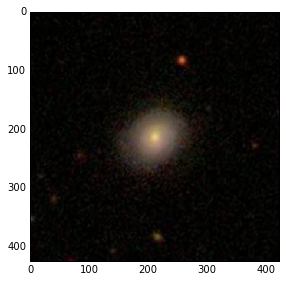

(424, 424, 3)

In [43]:
io.imshow(galaxy)
io.show()
galaxy.shape

424x424 pixels, with three color channels? Yeah, we don't need all of that. Let's make it 50x50 and black & white instead.

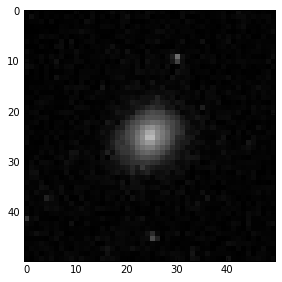

In [6]:
from skimage import transform, color
smallgalaxy = transform.resize(galaxy, (50, 50))
smallbwgalaxy = color.rgb2gray(smallgalaxy)
io.imshow(smallbwgalaxy)
io.show()

Much better. But that's an elliptical galaxy — can we still resolve the arms of a spiral galaxy, or the bars, or the "odd features" that are part of the Galaxy Zoo decision tree?

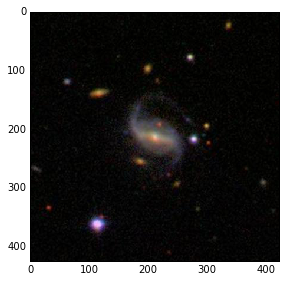

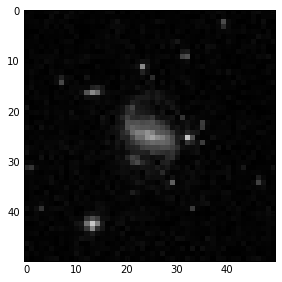

In [61]:
fn = np.random.choice(training_filenames)
randgalaxy = io.imread("images_training_rev1/" + fn)
randsmallgalaxy = color.rgb2gray(transform.resize(randgalaxy, (50, 50)))
io.imshow(randgalaxy)
io.show()
io.imshow(randsmallgalaxy)
io.show()

That's...not great. If you showed me the lower image without seeing the upper one, I might think it was an elliptical galaxy, rather than a spiral. How does 100x100 compare?

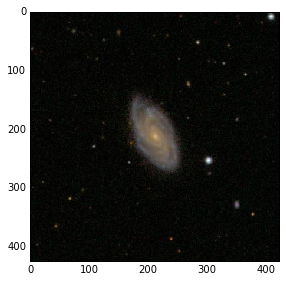

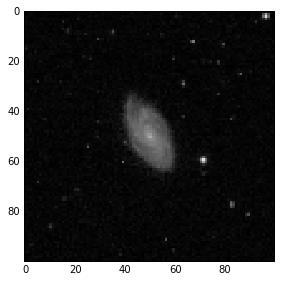

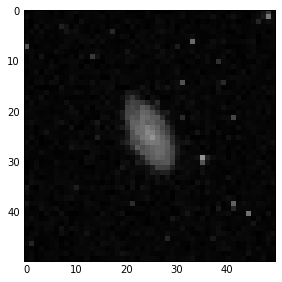

In [66]:
fn = np.random.choice(training_filenames)
randgalaxy = io.imread("images_training_rev1/" + fn)
randsmallgalaxy = color.rgb2gray(transform.resize(randgalaxy, (50, 50)))
randmedgalaxy = color.rgb2gray(transform.resize(randgalaxy, (100, 100)))
io.imshow(randgalaxy)
io.show()
io.imshow(randmedgalaxy)
io.show()
io.imshow(randsmallgalaxy)
io.show()

OK, looks like we might want to go up to 100x100. Let's try 50x50 first, though, and then go back up to 100x100 later.

**Splitting the training set and creating a pipeline**

Unfortunately, the only way to check our guesses for the test images is to submit the guesses to Kaggle. We don't want to do that every time — so let's train our machine-learning algorithms on half of our training set (randomly selected), and use the other half as our "test" set. If we end up with an algorithm that performs well on that test set, we'll retrain the algoritm on the entire training set, then use the actual test set to create a submission to Kaggle.

In [7]:
import random
shuffled_training_set = list(zip(training_filenames, training_solutions_array))
random.shuffle(shuffled_training_set)
small_training_set = shuffled_training_set[:n_files//2]
small_test_set = shuffled_training_set[n_files//2:]
print(len(small_training_set), len(small_test_set))
small_training_filenames = [i[0] for i in small_training_set]
small_training_answers = [i[1] for i in small_training_set]
small_test_filenames = [i[0] for i in small_test_set]
small_test_answers = [i[1] for i in small_test_set]

30789 30789


We'll also need a pipeline function for these images:

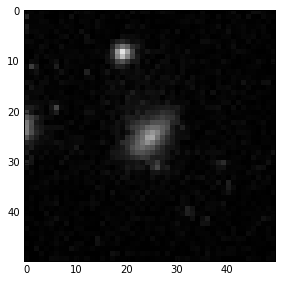

In [8]:
def downsample_and_grayscale(filename, size):
    '''
    Grabs the file, scales it down to the given size (in pixels), and grayscales it.
    Returns a numpy array with the downscaled and grayscaled image data.
    '''
    raw_image = io.imread("images_training_rev1/" + filename)
    downscaled_gray_image = color.rgb2gray(transform.resize(raw_image, (size, size)))
    return downscaled_gray_image

io.imshow(downsample_and_grayscale(small_training_filenames[2], 50))
io.show()

How fast is our pipeline? It might be too slow.

In [59]:
n = 300
pix = 10
t1 = time.time()
images = [downsample_and_grayscale(fn, pix) for fn in small_training_filenames[:n]]
t2 = time.time()
print("Processed", n, "images at", pix, "x", pix, "resolution in", t2-t1, "seconds.")

Processed 300 images at 10 x 10 resolution in 4.7310240268707275 seconds.


Yeah, that looks slow. I bet the downsampling is taking the most time.

In [9]:
def downsample_only(filename, size):
    '''
    Grabs the file and scales it down to the given size (in pixels)t.
    Returns a numpy array with the downscaled image data.
    '''
    raw_image = io.imread("images_training_rev1/" + filename)
    downscaled_image = transform.resize(raw_image, (size, size))
    return downscaled_image

n = 300
pix = 100
t1 = time.time()
images = [downsample_only(fn, pix) for fn in small_training_filenames[:n]]
t2 = time.time()
print("Downscaled", n, "images to", pix, "x", pix, "resolution in", t2-t1, "seconds.")

def grayscale_only(filename):
    '''
    Grabs the file and grayscales it.
    Returns a numpy array with the grayscaled image data.
    '''
    raw_image = io.imread("images_training_rev1/" + filename)
    grayscaled_image = color.rgb2gray(raw_image)
    return grayscaled_image

n = 300
t1 = time.time()
images = [grayscale_only(fn) for fn in small_training_filenames[:n]]
t2 = time.time()
print("Grayscaled", n, "images in", t2-t1, "seconds.")

Downscaled 300 images to 100 x 100 resolution in 10.95303988456726 seconds.
Grayscaled 300 images in 6.465637922286987 seconds.


OK, looks like it's just file I/O that's taking up all of the time. 300 images seem to take about 6 seconds, so...0.02s per image? That's a long time! At that rate, reading in all the images in the smaller training set alone will take...

In [65]:
print(0.02*len(small_training_set)/60, "hours")

10.263 hours


So reading in all of the data from the full training and test sets will take about two days. And even if we speed that up with a few processors running in parallel, we're still looking at something that takes hours. And we'll need at least two gigs of RAM free — probably more like 4-8GB — if we want to read in all that data at once. So there's no way to significantly improve on the speed of the winning algorithm on my laptop — unless I can get away with using a small fraction of the training set. And even then, it'd take a long time to generate my guess for the answer. At least I can get around the RAM problem by only keeping a small fraction of the training set loaded into RAM at any one time...and maybe I can get around the file I/O problem with HDF5 or something like that. Let's look into this later.

For now, let's see what we can do with a small subset of the data. We're still not done with our pipeline: we need to flatten the image arrays.

In [10]:
def pipeline(fn, size):
    '''Downsamples, grayscales, and flattens.'''
    return downsample_and_grayscale(fn, size).flatten()

We're finally ready to start doing some machine learning. Let's grow a forest!

**Random Forest**

Let's start with something very simple: 200 images at 20x20 resolution, just to test our forest-growing abilities.

In [18]:
from sklearn.ensemble import RandomForestRegressor
size = 20
n_images = 200
randforest = RandomForestRegressor(n_estimators=100, 
                            n_jobs=4, verbose=1, warm_start=False)
X = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
X = np.array(X)
Y = np.array(small_training_answers[:n_images])
randforest.fit(X, Y)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [19]:
newX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
newX = np.array(newX)
newY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(newX)
print(newY.shape, predictedY.shape)
print(rmse(newY, predictedY))

(200, 37) (200, 37)
0.163019458705


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


That is surprisingly un-horrible! Let's see if we can do better with the same training set by altering the hyper-parameters (e.g. number of trees, number of pixels fed in, size of the training set, etc.) We'll change them one at a time, and see what gets us the biggest improvement. 

In [87]:
randforest2 = RandomForestRegressor(n_estimators=400, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest2.fit(X, Y)
predictedY = randforest2.predict(newX)
print("RMSE with more trees:", rmse(newY, predictedY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.7s


RMSE with more trees: 0.164698296042


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


In [85]:
n_images = 400
size = 20
longerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
longerX = np.array(longerX)
longerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=100, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(longerX, longerY)
testlongerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testlongerX = np.array(testlongerX)
testlongerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testlongerX)
print("RMSE with a larger training set:", rmse(predictedY, testlongerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.8s finished


RMSE with a larger training set: 0.156437728168


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [86]:
n_images = 200
size = 40
biggerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
biggerX = np.array(biggerX)
biggerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=100, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(biggerX, biggerY)
testbiggerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testbiggerX = np.array(testbiggerX)
testbiggerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testbiggerX)
print("RMSE with larger images:", rmse(predictedY, testbiggerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.0s finished


RMSE with larger images set: 0.164147792591


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Unsurprisingly, a larger training set wins. We'll have to find a way to get that to work before we can go any further with this, I think.

IV. Increasing the size of the training set
------------

Let's start by profiling our existing file I/O.

In [90]:
import cProfile
N = 800
offset = 400
cProfile.run("list(io.imread('images_training_rev1/' + fn) for fn in small_training_filenames[offset:N+offset])")

         203204 function calls in 38.234 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      800    0.001    0.000    0.006    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
      801    0.006    0.000   38.195    0.048 <string>:1(<genexpr>)
        1    0.040    0.040   38.234   38.234 <string>:1(<module>)
      800    0.005    0.000    0.005    0.000 BmpImagePlugin.py:54(_accept)
      800    0.002    0.000    0.002    0.000 GifImagePlugin.py:45(_accept)
      800    0.004    0.000    8.447    0.011 Image.py:1128(getdata)
     1600    0.003    0.000    0.003    0.000 Image.py:1691(seek)
      800    0.002    0.000    0.002    0.000 Image.py:2235(_decompression_bomb_check)
      800    0.035    0.000   16.677    0.021 Image.py:2249(open)
      800    0.027    0.000    0.319    0.000 Image.py:2291(_open_core)
      800    0.002    0.000    0.002    0.000 Image.py:277(_conv_type_shape)
      800    0.004    0.00

OK, that's not terrible. Let's try a larger training set and see how we do.

In [91]:
n_images = 1000
size = 20
longerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
longerX = np.array(longerX)
longerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=100, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(longerX, longerY)
testlongerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testlongerX = np.array(testlongerX)
testlongerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testlongerX)
print("RMSE with a larger training set:", rmse(predictedY, testlongerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.2s finished


RMSE with a larger training set: 0.150243672651


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Not bad -- we're about a third of the way up the [leaderboard](https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/leaderboard/public) on Kaggle. Let's make the images bigger now and see if that helps.

In [92]:
n_images = 1000
size = 50
longerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
longerX = np.array(longerX)
longerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=100, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(longerX, longerY)
testlongerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testlongerX = np.array(testlongerX)
testlongerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testlongerX)
print("RMSE with a larger training set and larger images:", rmse(predictedY, testlongerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.8min finished


RMSE with a larger training set and larger images: 0.147535680338


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


OK, that gained us a few leaderboard spots. Let's try making the images bigger again, and increasing the number of trees to compensate for the larger input vectors. Increasing those individually didn't help before, but doing it in tandem might.

In [93]:
n_images = 1000
size = 100
longerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
longerX = np.array(longerX)
longerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=400, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(longerX, longerY)
testlongerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testlongerX = np.array(testlongerX)
testlongerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testlongerX)
print("RMSE with a larger training set, a bigger forest, and much larger images:", rmse(predictedY, testlongerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.0min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 30.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s


RMSE with a larger training set, a bigger forest, and much larger images: 0.146889039777


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.4s finished


Ok, let's try 50x50 images with more trees, since we probably didn't fully sample the space there.

In [94]:
n_images = 1000
size = 50
longerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
longerX = np.array(longerX)
longerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=500, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(longerX, longerY)
testlongerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testlongerX = np.array(testlongerX)
testlongerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testlongerX)
print("RMSE with a larger training set and larger images:", rmse(predictedY, testlongerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  9.4min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


RMSE with a larger training set and larger images: 0.146675323561


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.4s finished


Wow, that's not a lot better! So that means the way to crank down that RMSE on a pixel-based approach is really just to crank up the number of images. Let's do that.

In [12]:
n_images = 3000
size = 20
longerX = [pipeline(fn, size) for fn in small_training_filenames[:n_images]]
longerX = np.array(longerX)
longerY = np.array(small_training_answers[:n_images])
randforest = RandomForestRegressor(n_estimators=100, 
                            n_jobs=4, verbose=1, warm_start=False)
randforest.fit(longerX, longerY)
testlongerX = [pipeline(fn, size) for fn in small_training_filenames[n_images:2*n_images]]
testlongerX = np.array(testlongerX)
testlongerY = np.array(small_training_answers[n_images:2*n_images])
predictedY = randforest.predict(testlongerX)
print("RMSE:", rmse(predictedY, testlongerY))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   54.1s finished


RMSE: 0.14346268324


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Nope. I think we've reached the limits of what random forest is capable of when acting on raw pixels. We'd need to run something with a huge forest and large images on the whole dataset to be sure, but I doubt we'd get much better. Time to try something else.

V. Pulling out features of the images and trying again
-------------

VI. Messing around with a few other ideas
----------

**Gaussian processes**

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as SquaredExponential
from sklearn.gaussian_process.kernels import ConstantKernel as Amplitude

kernel = Amplitude(1.0, (1E-3, 1E3)) * SquaredExponential(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, Y)

predictedY = gp.predict(newX)
print(rmse(newY, predictedY))
len(newX)

0.180479375316


200

All three color channels?

Dealing with the pictures at their original resolution? (I doubt that would help, since it's not helpful to us.)

VII. Deep learning with Keras and Tensorflow
----------

VIII. Can we beat the best answer?
----------------